# Topic analysis of speeches in the Swedish Riksdag 2017-2021

In [1]:
# Standard packages
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sci-kit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# NLP packages
import torch
import stanza
# stanza.download('sv') # Download Swedish model, persists once downloaded

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## Load data and merge to one data set

In [2]:
speeches1718 = pd.read_csv('anforande-201718.csvt', sep=',')
speeches1819 = pd.read_csv('anforande-201819.csvt', sep=',')
speeches1920 = pd.read_csv('anforande-201920.csvt', sep=',')
speeches2021 = pd.read_csv('anforande-202021.csvt', sep=',')

speeches = speeches1718.append([speeches1819, speeches1920, speeches2021], ignore_index=True)
speeches.head()

,dok_id,dok_rm,dok_nummer,dok_datum,avsnittsrubrik,kammaraktivitet,anforande_nummer,talare,parti,anforandetext,intressent_id,rel_dok_id,replik
0,H5091,2017/18,1,2017-09-12 00:00:00,Inledning,NaN,1,TALMANNEN,TALMANNEN,Inledning Jag ber att få hälsa alla hjärtlig...,NaN,NaN,N
1,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:619 om dödsfall...,interpellationsdebatt,1,Socialministern Annika Strandhäll (S),S,Svar på interpellationer Herr talman! Jeff A...,5.304252e+11,H5C120170926ip,N
2,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:621 om brister ...,interpellationsdebatt,10,Socialministern Annika Strandhäll (S),S,Herr talman! Lotta Finstorp har frågat mig vi...,5.304252e+11,H5C120170926ip,N
3,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:621 om brister ...,interpellationsdebatt,11,Lotta Finstorp (M),M,Herr talman! Jag tackar ministern för svaret....,7.505186e+11,H5C120170926ip,N
4,H50910,2017/18,10,2017-09-26 00:00:00,Svar på interpellation 2016/17:621 om brister ...,interpellationsdebatt,12,Socialministern Annika Strandhäll (S),S,Herr talman! Jag tackar Lotta Finstorp för de...,5.304252e+11,H5C120170926ip,N


In [3]:
parties = ['S', 'M', 'MP', 'SD', 'KD', 'V', 'L', 'C', '-']
party_color = ['red', 'mediumblue', 'limegreen', 'gold', 'navy', 'darkred', 'cornflowerblue', 'green', 'black']
color_dict = dict(zip(parties, party_color))

# Select only the political speeches (exclude His Majesty the King,
# the Speaker, and the role of the most senior senator)
speeches = speeches[speeches.parti.isin(parties)]

# Data inspection

### Number of speeches per party and per period

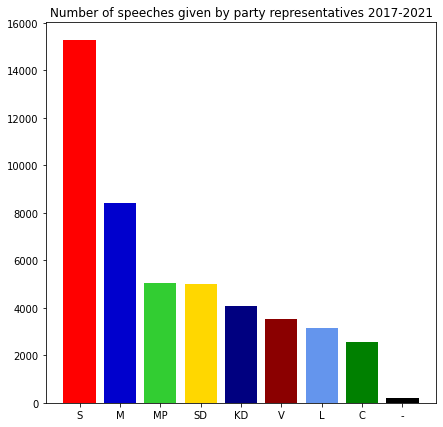

In [4]:
plt.figure(figsize=(7,7))
plt.bar(parties, speeches.parti.value_counts(), color = party_color)
plt.title('Number of speeches given by party representatives 2017-2021')
plt.show()

### Distribution over time

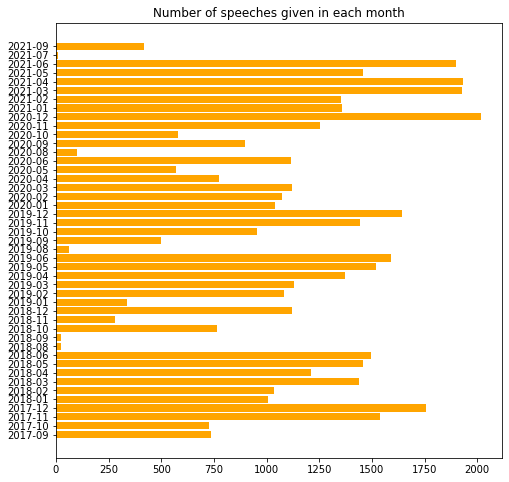

In [5]:
def get_month(time_str):
    # Takes a string 'yyyy-mm-dd xx:xx:xx' and returns 'yyyy-mm'
    time = time_str.split('-')
    month = '-'.join(time[0:2])
    return month
    
dates = list(map(get_month, speeches.dok_datum.to_list()))
unique, counts = np.unique(dates, return_counts=True)

plt.figure(figsize=(8,8))
plt.barh(unique, counts, color='orange')
plt.title('Number of speeches given in each month')
plt.show()

### Distribution of speech lengths

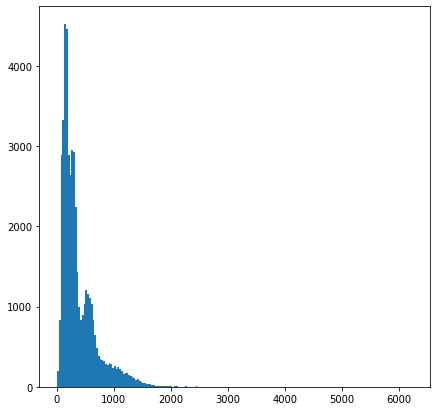

In [6]:
speech_lengths = []
for sp in speeches.anforandetext.values:
    speech_lengths.append(len(sp.split(' ')))

plt.figure(figsize=(7,7))
plt.hist(speech_lengths, bins=200)
plt.show()

### Types of activities and subjects

In [7]:
speeches.kammaraktivitet.value_counts(dropna=False)

ärendedebatt                  16336
interpellationsdebatt         13412
NaN                            8765
frågestund                     6804
statsministerns frågestund      930
aktuell debatt                  897
Name: kammaraktivitet, dtype: int64

In [8]:
subjects = speeches.avsnittsrubrik.value_counts().index
cts = speeches.avsnittsrubrik.value_counts().values
for i in range(len(cts)):
    print(subjects[i], cts[i])

Frågestund 6804
Partiledardebatt 1420
Statsministerns frågestund 878
Utrikespolitisk debatt 707
Återrapportering från Europeiska rådets möte 447
Allmänpolitisk debatt (forts. från prot. 7) 399
Debatt med anledning av vårpropositionens avlämnande 284
Debatt med anledning av budgetpropositionens avlämnande 277
Samhällsplanering, bostadsförsörjning och byggande samt konsumentpolitik 232
Utbildning och universitetsforskning 227
Kommunikationer 222
Näringsliv 188
Rättsväsendet 178
Hälsovård, sjukvård och social omsorg 176
Partiledardebatt med anledning av val till Europaparlamentet 168
Allmän miljö- och naturvård 163
Kultur, medier, trossamfund och fritid 162
Jämställdhet och nyanlända invandrares etablering 152
Allmänpolitisk debatt (forts. från prot. 8) 151
Energi 142
Studiestöd 141
Ekonomisk trygghet vid sjukdom och funktionsnedsättning 134
Arbetsmarknad och arbetsliv och Arbetsmarknadspolitik och arbetslöshetsförsäkringen 133
EU-politisk debatt 128
Statens budget 2021 - rambeslutet 125


Ett tryggt och mer hållbart premiepensionssystem 10
En effektivare kommunal räddningstjänst 10
Svar på interpellation 2020/21:20 om idrottsutbildningar i gymnasie- och gymnasiesärskola 10
Svar på interpellationerna 2017/18:137 och 160 om tidsgränserna i rehabiliteringskedjan 10
Beskattning av uthyrning av vårdpersonal 10
Svar på interpellationerna 2017/18:305 och 307 om stödet till diktaturens Iran 10
Renodling av Polismyndighetens arbetsuppgifter när länsstyrelserna tar över uppgifter på djurområdet 10
Svar på interpellationerna 2019/20:30 och 51 om Turkiets invasion i norra Syrien 10
Svar på interpellationerna 2017/18:221 och 235 om biogas 10
Svar på interpellationerna 2017/18:131 och 261 om åtgärder för att skydda företagare mot djurrättsaktivister 10
(forts. från § 5) Naturvård och biologisk mångfald (forts. MJU15) 10
Svar på interpellationerna 2019/20:102 och 116 om Svenska institutets marknadsföring av Sverige 10
Svar på interpellationerna 2019/20:398 och 399 om stöd till regiona

Svar på interpellation 2019/20:348 om Sveriges arkivpolitik 7
Svar på interpellation 2019/20:338 om villkorat bistånd till fler länder 7
Svar på interpellation 2017/18:66 om svensk bnp-tillväxt 7
Svar på interpellation 2017/18:102 om utvärderingen av statens idrottspolitiska mål 7
Svar på interpellation 2019/20:344 om Postnords upphandling av transporter 7
Svar på interpellation 2017/18:142 om jobbskatteavdrag för äldre 7
Svar på interpellation 2017/18:64 om prioriteringar inom penningpolitiken 7
Svar på interpellation 2019/20:311 om bränsle- och fordonsskatter 7
Svar på interpellation 2017/18:72 om psykisk ohälsa 7
Svar på interpellation 2019/20:303 om reseavdraget och skatt på drivmedel 7
Svar på interpellation 2017/18:101 om planerna på en nationell antidopningsorganisation 7
Svar på interpellation 2019/20:210 om utnyttjandet av samordningsnummer 7
Svar på interpellation 2019/20:351 om hatbrott mot svenskar 7
Svar på interpellation 2018/19:309 om diplomatiska garantier 7
Svar på int

Svar på interpellation 2020/21:68 om den turkiska regimens expansiva utrikespolitik 7
Svar på interpellation 2020/21:125 om hastighetssänkning på E14 7
Svar på interpellation 2020/21:129 om externa stationslägen 7
Svar på interpellation 2020/21:705 om Riksrevisionens rapport om besiktningsmarknaden 7
Svar på interpellation 2017/18:490 om åtgärder för att nå miljömålen 7
Svar på interpellation 2017/18:517 om trafikregler som påverkar cyklister 7
Svar på interpellation 2020/21:183 om arbetsmarknaden i Strömstad 7
Svar på interpellation 2020/21:202 om bidrag till extremism i civilsamhället 7
Svar på interpellation 2020/21:177 om barn och ungdomar som slutar idrotta 7
Svar på interpellation 2020/21:181 om bättre tillgång till läkemedelsassisterad behandling vid opioidberoende 7
Svar på interpellation 2020/21:180 om överförskrivning och missbruk av narkotikaklassade läkemedel 7
Svar på interpellation 2020/21:165 om den tillfälliga lagen om utökat mandat för regeringen under pandemin 7
Svar 

Svar på interpellation 2018/19:127 om återtagandeavtalet med Afghanistan 7
Svar på interpellation 2020/21:360 om stölder och olaglig godstrafik 7
Svar på interpellation 2017/18:401 om arbetskraftsinvandring och kompetensförsörjning 7
Svar på interpellation 2017/18:414 om integrationsutmaningen 7
Svar på interpellation 2018/19:137 om rättsstatens principer i Rumänien 7
Svar på interpellation 2018/19:133 om lantmäteriernas funktion 7
Svar på interpellation 2017/18:356 om hög och störande musik från fordon 7
Svar på interpellation 2018/19:123 om Turkiet inför valet 2019 7
Svar på interpellation 2018/19:121 om konsumentinformation 7
Svar på interpellation 2018/19:103 om en fungerande återvändandepolitik 7
Svar på interpellation 2017/18:427 om svensk försvarsnära industri 7
Svar på interpellation 2018/19:102 om kompetensutvisningar 7
Svar på interpellation 2018/19:138 om sexualbrottsutredningar 7
Svar på interpellation 2018/19:76 om fastighetsägarnas ansvar för gaturenhållning 7
Svar på int

(forts. från § 9) Svar på interpellation 2020/21:575 om älvdalskan som nationellt minoritetsspråk 4
Nytt särskilt bidrag inom bostadsbidraget för barn som bor växelvis 4
Diskussionsunderlag om en fördjupad ekonomisk och monetär union 4
Diskussionsunderlag om framtiden för EU:s finanser  4
En amnesti för explosiva varor 4
Svar på interpellation 2020/21:523 om milt väder som försämrar vägarnas skick 3
(forts. från § 9) Kommunala frågor (forts. FiU26) 3
(forts.) Svar på interpellation 2020/21:417 om antisemitism i de palestinska områdena 3
(forts. från § 7) Svar på interpellation 2020/21:469 om sjukförsäkringen, samverkansproblem och SGI 3
Skadeståndets omfattning vid finansiell rådgivning 3
Svar på interpellationerna 2020/21:366, 369 och 370 om riksintressen och planerade stambanan mellan Göteborg och Borås 3
Subsidiaritetsprövning av kommissionens ändrade förslag till beslut om Europeiska unionens egna medel  3
Ekonomiskt partnerskapsavtal mellan Europeiska unionen och dess medlemsstate

# Vectorize speeches
We begin by loading the processing pipeline. We find the names of the speakers so that they can be removed from the speeches later. We also import stop words for politics from https://github.com/peterdalle/svensktext/tree/master/stoppord by Dahlgren, P. M., extended by me with words included in the data set speeches, such as 'talman', 'herr', 'fru', 'mergeformat', 'kantrubrik' etc (the latter are formatting commands that for some reason are included in the speeches).

The standard pipeline has some issues with certain words, create a custom one instead

In [65]:
# Initialize Swedish neural pipeline
# nlp = stanza.Pipeline('sv') # Standard options
# nlp = stanza.Pipeline('sv', processors='tokenize,pos,lemma', use_gpu=True, pos_batch_size=3000)

user_name = ''

# Create custom pipeline
model = torch.load(f'C:/Users/{user_name}/stanza_resources/sv/lemma/talbanken.pt', map_location='cpu')
word_dict, composite_dict = model['dicts']

def add_word(word, lemma, w_class):
    composite_dict[(word, w_class)] = lemma
    word_dict[word] = lemma

# Add words that are correctly handled in the pretrained pipeline.
# 'skola' especially causes trouble
add_word('skola', 'skola', 'NOUN')
add_word('ska', 'ska', 'AUX')
add_word('ska', 'ska', 'VERB')
add_word('yrka', 'yrka', 'VERB')
add_word('yrkar', 'yrka', 'VERB')
add_word('vikten', 'vikt', 'NOUN')

torch.save(model, f'C:/Users/{user_name}/stanza_resources/sv/lemma/talbanken_customized.pt')

nlp_custom = stanza.Pipeline('sv', processors='tokenize,pos,lemma', lemma_model_path=f'C:/Users/{user_name}/stanza_resources/sv/lemma/talbanken_customized.pt')

2021-12-12 16:29:37 INFO: Loading these models for language: sv (Swedish):
| Processor | Package                 |
---------------------------------------
| tokenize  | talbanken               |
| pos       | talbanken               |
| lemma     | C:/Users/j...tomized.pt |

2021-12-12 16:29:37 INFO: Use device: cpu
2021-12-12 16:29:37 INFO: Loading: tokenize
2021-12-12 16:29:37 INFO: Loading: pos
2021-12-12 16:29:38 INFO: Loading: lemma
2021-12-12 16:29:38 INFO: Done loading processors!


In [10]:
# Preprocessor that may be passed to the vectorizer
def preprocess(text):
    doc = nlp_custom(text)
    tokens = []
    for sentence in doc.sentences:
        tokens.extend([word.lemma for word in sentence.words])
    return tokens

In [29]:
# Find names
names = ' '.join(list(speeches.talare.unique())).split(' ')
name_df = pd.DataFrame(names, columns=['names'])
name_df = name_df.drop_duplicates().sort_values(by='names')
name_df.head()
names = list(name_df.names)

# Remove titles and party tags, and transform to lower case
names_lc = [name.lower() for name in names if 'minister' not in name and 'Statsrådet' not in name and '(' not in name]
# print(names_lc)

# Import stopwords
stoppord = pd.read_csv('stoppord-politik-komp16-2021-12-08.csv', encoding='utf-16')
stop_words_ = list(stoppord.word)

stop_words_.extend(names_lc)

# print(stop_words_)

# Preprocess and remove duplicates
sw = set(preprocess(' '.join(stop_words_)))
print(len(sw))
print(sw)

1090
{'ingemar', 'lätt', 'ebba', 'pål', 'varför', 'kr', 'jabar', 'lindahl', 'waltersson', 'gå', 'hallberg', 'r', 'sju', 'ferm', 'hedin', 'höja', 'avsan', 'sanne', 'än', 'svantesson', 'christer', 'delgado', 'dibrani', 'nordmark', 'nordquist', 'karap', 'wallström', 'sail', 'ask', 'thorbjörnson', 'bucht', 'millard', 'jonsson', 'annika', 'anders', 'karl', 'vid', 'laitinen', 'brunegård', 'då', 'lundqvist', 'busch', 'malcolm', 'szatmari', 'thomsson', 'marco', 'lövin', 'hon', 'nionde', 'broman', 'kjell-arne', 'wallrup', 'petter', 'ankarberg', 'w', 'sextio', 'sån', 'nödvändig', 'andersson', 'meijer', 'lundgren', 'azad', 'sandell', 'rågsjö', 'få', 'jag', 'johan', 'enkel', 'tidig', 'stenkvist', 'annelie', 'sven-erik', 'smith', 'batra', 'henrik', 'anna-lena', 'eller', 'sjöblom', 'warborn', 'barenfeld', 'maj', 'emilsson', 'von', 'övre', 'ernkrans', 'bolund', 'men', 'gamov', 'modig', 'kuhnke', 'idag', 'slutligen', 'löfven', 'kinnunen', 'plass', 'bonnier', 'bergström', 'imorgon', 'dioukarev', 'sexto

In [12]:
# Sort and save updated stop word list
#stoppord_ = pd.DataFrame(list(sw), columns=['word'])
#stoppord_ = stoppord_.sort_values(by='word').drop_duplicates()
#stoppord_.to_csv('stoppord-politik-v2-utf16-2021-12-08.csv', index=False, encoding='utf-16')

In [13]:
# Join speeches for speed, results in a single document which is not desireable, use custom_preprocess instead
joint_speeches = "\n\n".join(speeches.anforandetext.sample(500).values)

In [14]:
# Custom preprocessor using stanza documents
def custom_preprocess(df, n_samples, random=False):
    """
    Function that takes a data frame and returns
    a list of strings (one for each document) that
    are lemmatized.
    
    Input:
        - df: A data frame of speeches
        - n_samples: the number of documents to extract
        - random: boolean indicating random sampling (optional)
    
    Returns:
        - A list of strings with lemmatized documents.
    
    """
    text = df.anforandetext
    if n_samples > len(speeches):
        n_samples = len(speeches)
        
    # Wrap each document with a stanza.Document object
    if random:
        in_docs = [stanza.Document([], text=d) for d in text.sample(n_samples).values]
    else:
        in_docs = [stanza.Document([], text=d) for d in text.values[0:n_samples]]

    t = time.time()
    out_docs = nlp_custom(in_docs)

    tokens = []
    for doc in out_docs:
        tokens_ = []
        for sentence in doc.sentences:
            tokens_.extend([word.lemma for word in sentence.words])
        tokens.append(' '.join(tokens_))

    t = time.time() - t
    print(f'Time taken for {n_samples} speeches:', str(t)[0:6], 'seconds')
    
    return tokens

In [15]:
n_docs = 5000
tokens = custom_preprocess(speeches, n_docs, random=True)

Time taken for 5000 speeches: 2650.6 seconds


__Not using the POS tagger speeds up the processing, but the result is worse - the words are not properly lemmatized.__

Verify that the preocessed text looks reasonable:

In [16]:
print(tokens[0:2])

['Herr talman ! en nuvarande generaldirektör för arbetsförmedling utså av en tidig borgerlig regering . arbetsförmedling vara när han tillträda en myndighet i fri fall med oerhörd stor problem . man ha stabilisera utveckling och i flera avseende gå den åt rätt håll - dock inte i all avseende . STYLEREF kantrubrik \\ * MERGEFORMAT frågestund jag bedömning vara att arbetsförmedling fortsätta att ha stor brist men jag tänka inte medverka till att göra arbetsförmedling till någon allmän spottkopp i debatt för den vara inte berättiga . den pågå också väldig mycket bra arbete . arbetsförmedlare göra dagligen fantastisk bra arbete och hjälpa människa till jobb och hjälpa arbetsgivare att få tag i rätt personal . men den finnas också anledning till kritik och den finnas anledning att förändra en hel del inom arbetsförmedling . svar på fråga vara att jag ha förtroende för arbetsförmedling generaldirektör . ( applåd )', 'fru talman ! jag ska börja med att erkänna för talman församling och de som

In [ ]:
# Needs no processor if tokenized from the beginning
vectorizer = TfidfVectorizer(stop_words=sw) # tokenizer=preprocess)
speech_vec = vectorizer.fit_transform(tokens)

# vectorizer = TfidfVectorizer(stop_words=sw, tokenizer=preprocess)
# speech_vec = vectorizer.fit_transform(speeches.anforandetext.sample(500))

In [31]:
vocab = vectorizer.vocabulary_
inv_vocab = {val:key for key, val in vocab.items()}

print(speech_vec.shape)

(5000, 38251)


Print the 200 most common words, and the 200 least common words

In [32]:
ix = np.argsort(vectorizer.idf_)
common_words = []
for i in ix[:300]:
    common_words.append( inv_vocab[i] )
print(common_words)

print('')
uncommon_words = []
for i in ix[-200:]:
    uncommon_words.append( inv_vocab[i] )
print(uncommon_words)

['regering', 'sverige', 'land', 'svensk', 'handla', 'tycka', 'tid', 'många', 'väldig', 'möjlighet', 'förslag', 'öka', 'människa', 'arbete', 'exempel', 'just', 'tydlig', 'fortsätta', 'ställa', 'riksdag', 'problem', 'innebära', 'debatt', 'använda', 'politik', 'sak', 'faktisk', 'åtgärd', 'samhälle', 'hålla', 'bygga', 'område', 'grund', 'ansvar', 'tänka', 'visa', 'arbeta', 'samtidig', 'ske', 'stöd', 'ställe', 'person', 'utveckling', 'eu', 'antal', 'precis', 'egen', 'leda', 'minska', 'skapa', 'börja', 'låta', 'kräva', 'tala', 'myndighet', 'svår', 'välja', 'parti', 'moderat', 'behov', 'väg', 'förutsättning', 'situation', 'följa', 'pengar', 'kommun', 'yrka', 'jobba', 'utredning', 'verksamhet', 'företag', 'bifall', 'höra', 'stärka', 'bidra', 'anse', 'barn', 'naturligtvis', 'genomföra', 'ytterlig', 'stark', 'sätta', 'plats', 'politisk', '000', 'titta', 'driva', 'värld', 'försöka', 'utveckla', 'ekonomisk', 'stat', 'ganska', 'införa', 'insats', 'kalla', 'konstatera', 'fungera', 'sida', 'gemensam'

## Clustering
Try different numbers of clusters and inspect the cluster topics.

In [20]:
def get_cluster_topics(cluster_centers, n=10, print_=True):
    """
    Returns a list of lists containing the most relevant
    words for each type of speech in each cluster
    
    Parameters:
        - cluster_centers: a list containing the cluster cent
        - n: integer specifying how many words should be returned
    
    Returns:
        - A list of lists containing the n highest
          weighted terms in each cluster
    """
    topics = []
    for c in cluster_centers:
        ix_sort = np.argsort(-c)
        topic = []
        for i in ix_sort[:n]:
            topic.append(inv_vocab[i])
        topics.append(topic)
        if print_:
            print(topic)
            
    return topics

In [ ]:
n_cl = [1+2*i for i in range(4,70)]
param_grid_ = {'n_clusters': n_cl}
kmeansCV = GridSearchCV(estimator=KMeans(random_state=200), param_grid=param_grid_,
                        scoring=None, n_jobs=-1, refit=True, cv=None)
kmeansCV.fit(speech_vec, None)

In [ ]:
best_n_clusters = kmeansCV.best_params_['n_clusters']
print(best_n_clusters)
print(n_cl)

It seems that having many clusters gives a better result, perhaps to the point that the model just recreates the labels of the data. The fact that the feature space has many dimensions (one for each word) might reward a model with many clusters.

The topics definitely become more specific using a higher number of clusters. With e.g. 2000 speeches, using about 100 clusters only allow for on average 20 documents in each cluster.

In [ ]:
topicsCV = get_cluster_topics(kmeansCV.best_estimator_.cluster_centers_, n=100, print_=False)

In [ ]:
print(topicsCV[23])

In [33]:
nc = 39
kmeans39 = KMeans(n_clusters = nc, n_init=20)
kmeans39.fit(speech_vec)

KMeans(n_clusters=39, n_init=20)

In [34]:
topics = get_cluster_topics(kmeans39.cluster_centers_, n=100, print_=False)

In [ ]:
# Extracted topics
interpreted_topics = ['nuclear power', 'education', '', 'climate', 'foreign politics', 'housing',
                     'crime/','equality','personal assistance','human rights/immigration',
                     'housing2/welfare (fuzzy)','infrastructure (fuzzy)','countryside (fuzzy)','EU','healthcare']
topic_dict = dict(zip(range(n_clusters_), interpreted_topics))

The topics seem to encompass the areas welfare/healthcare, gender equality, human rights/world politics, crime and the judicial system, childrens rights, the educational system, the European Union, the climate, the job situation.

Adding a few clusters make the generated topics more specific: security and defence, and infrastructure and energy are two topics that appear more clearly, but at the same time we get more clusters that are unclear.

In [23]:
def plot_topic_distribution(predictions, topic_dict, party=None, title_=' '):
    n_clusters_ = len(topic_dict)
    
    col = 'gray'
    if party:
        col = color_dict[party]
        if title_ == ' ':
            title_ = f'Topic distribution of speeches by {party} politicians'        
    
    plt.figure(figsize=(8,8))
    n, bins, patches = plt.hist(predictions, bins=[i-0.5 for i in range(n_clusters_+1)], color=col, edgecolor='black')
    xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
    xticks_labels = [ f"{topic_dict[idx]}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
    plt.xticks(xticks, labels = xticks_labels, rotation='vertical')
    
    print("Cluster with most data points:", np.argmax(n))
    
    plt.title(title_)
    plt.show()

Show the distribution of speeches between the topic clusters

In [35]:
topic_dict = dict(zip(range(nc), range(nc)))

Cluster with most data points: 9


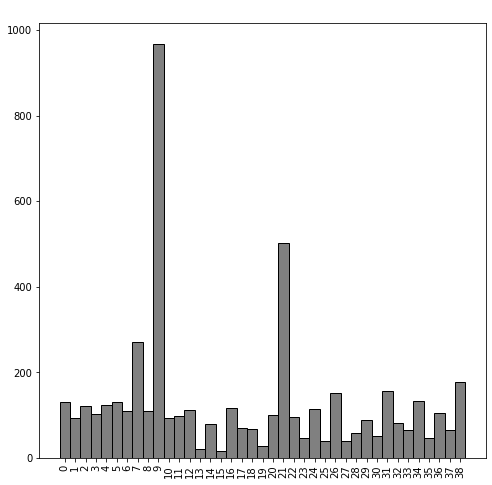

In [36]:
pred = kmeans39.predict(speech_vec)
#pred = kmeansCV.best_estimator_.predict(speech_vec)
plot_topic_distribution(pred, topic_dict)

In [37]:
print(topics[9])

['tycka', 'regering', 'väldig', 'ledamot', 'sverige', 'problem', 'handla', 'sak', 'debatt', 'tid', 'utredning', 'tänka', 'människa', 'svensk', 'just', 'höra', 'tala', 'många', 'parti', 'moderat', 'ställa', 'tacka', 'pengar', 'hålla', 'tydlig', 'precis', 'land', 'område', 'överens', 'avsluta', 'förslag', 'person', 'liberal', 'arbete', 'möjlighet', 'härmed', 'faktisk', 'titta', 'exempel', 'anförande', 'sida', 'åtgärd', 'naturligtvis', 'bygga', 'fatta', 'fortsätta', 'försöka', 'ske', 'öka', 'ganska', 'politik', 'vänsterparti', 'jobba', 'hoppas', 'prata', 'riksdag', 'lösning', 'förstå', 'budget', 'socialdemokrat', 'eu', 'använda', 'börja', 'svår', 'utrikesminister', 'diskussion', 'känna', 'läsa', 'innebära', 'stat', 'rverläggning', 'beredd', 'fel', 'svara', 'låta', 'betala', 'kammar', 'lagstiftning', 'situation', 'hända', 'väg', 'visa', 'hantera', 'typ', 'egentligen', 'assista', 'system', 'plats', 'minska', 'ansvar', 'samhälle', 'riktig', 'agera', 'följa', 'nämna', 'antal', 'stöd', 'utveck

In [38]:
print(topics[21])

['sverige', 'land', 'svensk', 'regering', 'människa', 'öka', 'eu', 'handla', 'utsläpp', 'minska', 'skatt', 'politik', 'hållbar', 'värld', 'väldig', 'exempel', 'samhälle', 'många', 'problem', 'moderat', 'tid', 'arbete', 'förslag', 'migrationspolitik', 'möjlighet', 'tycka', 'utveckling', 'miljö', 'mål', 'skapa', 'område', 'bygga', 'fortsätta', 'ansvar', 'just', 'företag', 'stark', 'visa', 'tydlig', 'faktisk', 'internationell', 'biologisk', 'person', 'grön', 'mångfald', 'åtgärd', 'använda', 'klara', 'regel', 'landsbygd', 'ställa', 'jordbruk', 'innebära', 'jobb', 'bidra', 'förutsättning', 'jobba', 'hålla', 'samtidig', 'grund', 'ekonomisk', 'produktion', 'arbeta', 'utveckla', 'uppehållstillstånd', 'sak', 'titta', 'debatt', 'global', 'parti', 'pengar', 'samarbete', 'leda', 'tala', 'långsiktig', 'gemensam', 'riksdag', 'ställe', 'nordisk', 'industri', 'låta', 'tillväxt', 'framtid', 'investering', 'ekonomi', 'naturligtvis', 'driva', 'ganska', 'antal', 'kräva', 'situation', 'socialdemokrat', 'om

## Clustering of speeches of individual parties
Applying the model on speeches from individual parties, as well as clustering of individual party speeches.

## MP

In [39]:
speeches_MP = speeches[speeches.parti == 'MP']

tokens_MP = custom_preprocess(speeches_MP, n_samples=2000)
speech_vec_MP = vectorizer.transform(tokens_MP)

Time taken for 2000 speeches: 926.69 seconds


In [40]:
kmeans_MP = KMeans(n_clusters = 11)
kmeans_MP.fit(speech_vec_MP)

topics_MP = get_cluster_topics(kmeans_MP.cluster_centers_, n=10)

['bostad', 'bygga', 'kommun', 'bostadsmarknad', 'investeringsstöd', 'sverige', 'bostadsbrist', 'människa', 'hyra', 'regering']
['budget', 'moderat', 'kristdemokrat', 'flygskatt', 'flyg', 'grön', 'miljö', 'skära', 'centerparti', 'utsläpp']
['barn', 'kulturskola', 'kultur', 'bibliotek', 'ung', 'land', 'förälder', 'kommun', 'stöd', 'regering']
['elev', 'lärare', 'förskoleklass', 'ämne', 'undervisning', 'stöd', 'rektor', 'undervisningstid', 'barn', 'möjlighet']
['regering', 'utredning', 'lagstiftning', 'förslag', 'myndighet', 'kommun', 'arbete', 'åtgärd', 'riksdag', 'förändring']
['public', 'service', 'oberoende', 'tv', 'sändningstillstånd', 'services', 'radio', 'kommitté', 'verksamhet', 'riksdag']
['sverige', 'land', 'människa', 'samhälle', 'regering', 'bistånd', 'arbete', 'rättighet', 'polis', 'fortsätta']
['kvinna', 'våld', 'feministisk', 'jämställd', 'arbete', 'regering', 'samhälle', 'rättighet', 'jämställdhet', 'utsätta']
['bil', 'utsläpp', 'sverige', 'regering', 'stad', 'elcykel', 'm

2000
Cluster with most data points: 9


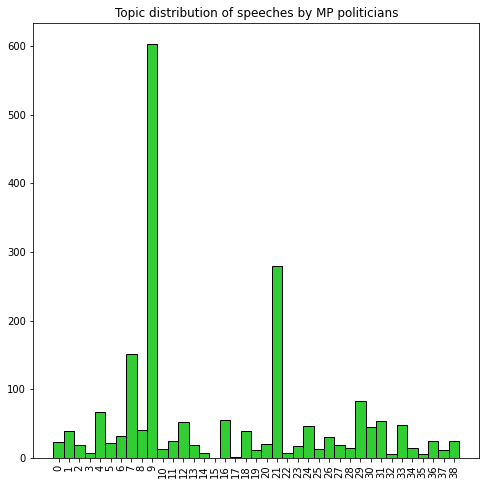

In [41]:
pred_MP = kmeans39.predict(speech_vec_MP)
#pred_MP = kmeansCV.best_estimator_.predict(speech_vec_MP)
print(len(pred_MP))
plot_topic_distribution(pred_MP, topic_dict, 'MP')

In [43]:
# Analyse the undefined categories

debate_MP_speeches_ix = np.where(pred_MP == 9)[0]
debate_MP_speeches = speeches_MP.iloc[debate_MP_speeches_ix,:].anforandetext.values

print(len(debate_MP_speeches_ix))

for sp in debate_MP_speeches[110:121]:
    print(sp[0:1000], "\n")

603
 Fru talman! Jag är ordförande i riksdagens trafikutskott  och jag har haft ett mycket bra samarbete med regeringen. Men att i det här sammanhanget förklara exakt varför planen inte kom i tid tycker jag inte ankommer på mig.  

 Fru talman! Jag håller med om Nina Lundströms uppfattning om att vi har ansträngt oss på olika håll. I det här betänkandet lyfter vi fram resonemang om samhällsekonomiska kalkylmodeller. De skulle till exempel förtjäna att vi fördjupar oss ännu mer i dem. Så som de har använts hittills har de nämligen inte varit ett speciellt bra redskap för att vaska fram de investeringar som lättast leder till de mål vi har satt upp.  Hela diskussionen om att låta målen styra det man vill åstadkomma har vi tagit upp i vår granskningsrapport. Vi har gjort tillkännagivanden om att ha en nationell tågtrafikförsörjningsplan i första hand och låta den styra den nationella planen. Jag håller alltså med om att vi har bidragit på olika sätt när det gäller att utveckla trafikpolit

## M

In [44]:
speeches_M = speeches[speeches.parti == 'M']

tokens_M = custom_preprocess(speeches_M, n_samples=500)
speech_vec_M = vectorizer.transform(tokens_M)

Time taken for 500 speeches: 268.08 seconds


In [45]:
kmeans_M = KMeans(n_clusters = 11)
kmeans_M.fit(speech_vec_M)

topics_M = get_cluster_topics(kmeans_M.cluster_centers_, n=10)

['sverige', 'svensk', 'industri', 'eu', 'tycka', 'företag', 'göteborg', 'land', 'vattenkraft', 'regering']
['person', 'regering', 'sverige', 'handla', 'företag', 'människa', 'skatt', 'bolag', 'många', 'regel']
['kafalah', 'barnkonvention', 'barn', 'inkorporering', 'svensk', 'artikel', 'inkorporera', 'haagkonvention', 'rättighet', 'statsråd']
['minister', 'pråmtrafik', 'regering', 'varg', 'tycka', 'sverige', 'skatt', 'inlandssjöfart', 'bil', 'strandskydd']
['polis', 'allians', 'polisutbildning', '000', 'räcka', '20', 'regering', 'solna', 'skylla', 'polisfråga']
['förslag', 'regering', 'läkemedelslista', 'moderat', 'utredning', 'lagstiftning', 'ungdom', 'riksdag', 'tycka', 'elev']
['kommun', 'bostad', 'regering', 'lidingö', 'kulturskola', 'kommunal', 'sverige', 'förslag', 'statsråd', 'allians']
['statsråd', 'försäkringsbolag', 'blankett', 'nämnd', 'arbetarrörelse', 'sverige', 'förtroende', 'polen', 'påverkan', 'tv']
['student', 'regering', 'sverige', 'högskola', 'utbildning', 'välfärd', 

Focus for M: housing market, educational system, foreign politics and defense, energy production, budget politics, crime and the judicial system.

500
Cluster with most data points: 9


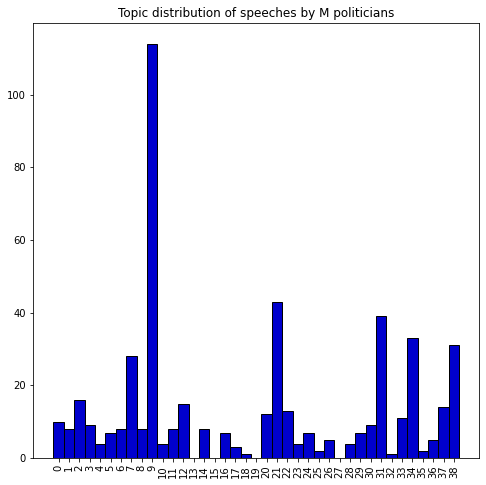

In [46]:
pred_M = kmeans39.predict(speech_vec_M)
#pred_M = kmeansCV.best_estimator_.predict(speech_vec_M)
print(len(pred_M))
plot_topic_distribution(pred_M, topic_dict, 'M')

## SD

In [47]:
speeches_SD = speeches[speeches.parti == 'SD']

tokens_SD = custom_preprocess(speeches_SD, n_samples=100)
speech_vec_SD = vectorizer.transform(tokens_SD)

Time taken for 100 speeches: 63.123 seconds


In [48]:
kmeans_SD = KMeans(n_clusters = 11)
kmeans_SD.fit(speech_vec_SD)

topics_SD = get_cluster_topics(kmeans_SD.cluster_centers_, n=10)

['förvaringsdom', 'person', 'straff', 'brott', 'farlig', 'kontaktförbud', 'kriminalvård', 'döma', 'livsfarlig', 'grov']
['utbildningsplats', 'regering', 'polis', 'terrorhot', 'polisfråga', 'sverigedemokrat', 'opposition', 'uran', 'föreslå', 'lån']
['omskärelse', 'barn', 'ingrepp', 'skyddsskäl', 'medicinsk', 'tobak', 'socialminister', 'argument', 'anledning', 'minderårig']
['sverigedemokrat', 'personlig', 'läkemedel', 'företag', 'eu', 'sverige', 'frihandelsunion', 'förslag', 'svensk', 'reservation']
['diskrimineringsgrund', 'diskrimineringslag', 'diskriminering', 'uppräkning', 'otillbörlig', 'regeringsform', 'parti', 'bostadsområde', 'omfatta', 'tala']
['förband', 'försvar', 'försvarsmakt', 'rekryteringskontor', 'brigad', 'berätta', 'officerare', 'militär', 'republik', 'utförsäkra']
['satsa', 'höghastighetsjärnväg', 'miljard', 'val', 'elväg', 'sverigedemokrat', 'järnväg', 'satsning', 'flykting', 'bygga']
['sjukvård', 'regering', 'lokförare', 'miljard', 'minister', 'sverigedemokrat', 'fö

100
Cluster with most data points: 9


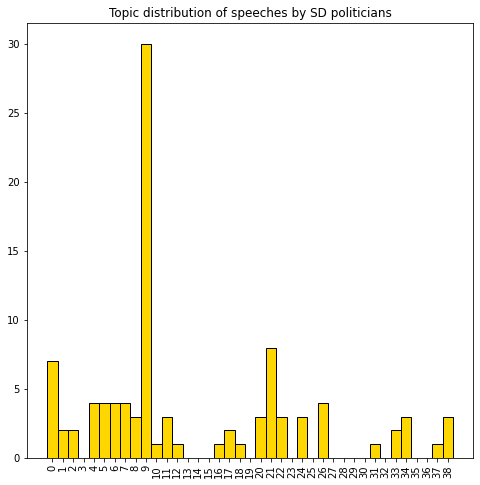

In [49]:
pred_SD = kmeans39.predict(speech_vec_SD)
#pred_SD = kmeansCV.best_estimator_.predict(speech_vec_SD)
print(len(pred_SD))
plot_topic_distribution(pred_SD, topic_dict, 'SD')

In [51]:
debate_SD_speeches_ix = np.where(pred_SD == 16)[0]
debate_SD_speeches = speeches_MP.iloc[debate_SD_speeches_ix,:].anforandetext.values

print(len(debate_SD_speeches_ix))

for sp in debate_SD_speeches[0:10]:
    print(sp[0:1000], "\n")

1
 Herr talman! Jag vet inte hur mycket statsvetenskap som riksdagsledamot Ahl har studerat  men det kanske kunde vara idé att gå hem och ta fram kurslitteraturen och läsa på om hur vi tar beslut i Sverige  hur man förändrar lagar och vad en majoritet i riksdagen innebär.  Den kommitté som arbetade fram förslaget på en skatt var en kommitté med ledamöter från alla riksdagens partier. De kom fram till detta förslag.  Argumenten för att riksdagens partier vill att man ska finansiera public service via skattsedeln handlar  enkelt uttryckt  om att public service är en del av demokratin och en garant för denna och för att makten - sådana som jag - granskas. Man förstår att man på sikt måste säkerställa finansieringen  och därför har man föreslagit detta. Vi får se om det blir så  men detta är förslaget från alla partier i Sveriges riksdag.  Jag vill återigen poängtera att just det faktum att vi är en demokrati  vår rätt att organisera oss och vår föreningsfrihet gör att riksdagsledamot Ahl 

## S

In [52]:
speeches_S = speeches[speeches.parti == 'S']

tokens_S = custom_preprocess(speeches_S, n_samples=300)
speech_vec_S = vectorizer.transform(tokens_S)

Time taken for 300 speeches: 156.37 seconds


In [53]:
kmeans_S = KMeans(n_clusters = 11)
kmeans_S.fit(speech_vec_S)

topics_S = get_cluster_topics(kmeans_S.cluster_centers_, n=10)

['försäkringskassa', 'sjukförsäkring', 'borgerlig', 'stöd', 'människa', 'sverigedemokrat', 'parti', 'arbetsgivare', 'tidsgräns', 'regering']
['regering', 'sverige', 'land', 'statlig', 'öka', 'åtgärd', 'svensk', 'handla', 'ekologisk', 'förslag']
['omskärelse', 'pojke', 'sedvänja', 'ingrepp', 'barnombudsman', 'vapen', 'funka', 'island', 'söka', 'pensionsöverenskommelse']
['sj', 'raoul', 'wallenberg', 'färdtjänst', 'insats', 'tåg', 'naturligtvis', 'gemensam', 'engagemang', 'förebygga']
['sjukvård', 'landsting', 'hälsa', 'vård', 'personal', 'barn', 'mandatperiod', 'satsning', 'psykiatri', 'regering']
['polis', 'narkotika', 'antal', 'narkotikabrott', 'polisutbildning', 'utbildningstakt', 'straffskärpning', 'nämna', 'rekryteringsmyndighet', 'arbetsuppgift']
['lagstiftning', 'utredare', 'fakultativ', 'stifta', 'hinna', 'utredning', 'omfattande', 'jourdomstol', 'förändra', 'jämförande']
['gotland', 'aktör', 'förnybar', 'energimyndighet', 'energi', 'energisystem', 'gotlänning', 'kabl', 'statsrå

300
Cluster with most data points: 9


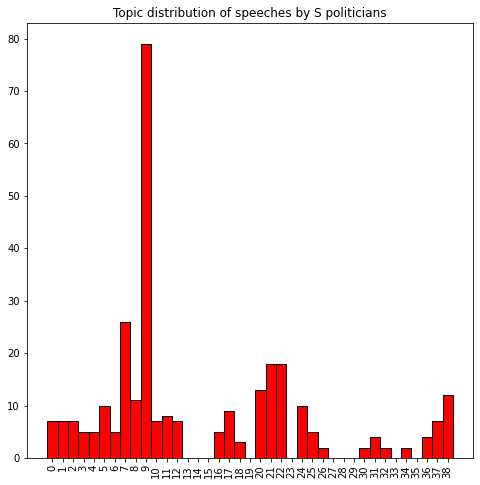

In [54]:
#pred_S = kmeansCV.best_estimator_.predict(speech_vec_S)
pred_S = kmeans39.predict(speech_vec_S)
print(len(pred_S))
plot_topic_distribution(pred_S, topic_dict, 'S')

## L

In [55]:
speeches_L = speeches[speeches.parti == 'L']

tokens_L = custom_preprocess(speeches_L, n_samples=300)
speech_vec_L = vectorizer.transform(tokens_L)

Time taken for 300 speeches: 174.01 seconds


300
Cluster with most data points: 9


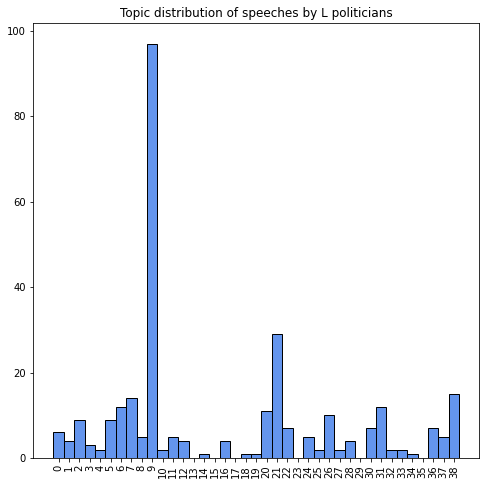

In [56]:
#pred_L = kmeansCV.best_estimator_.predict(speech_vec_L)
pred_L = kmeans39.predict(speech_vec_L)
print(len(pred_L))
plot_topic_distribution(pred_L, topic_dict, 'L')

## C

In [57]:
speeches_C = speeches[speeches.parti == 'C']

tokens_C = custom_preprocess(speeches_C, n_samples=300)
speech_vec_C = vectorizer.transform(tokens_C)

Time taken for 300 speeches: 173.17 seconds


300
Cluster with most data points: 9


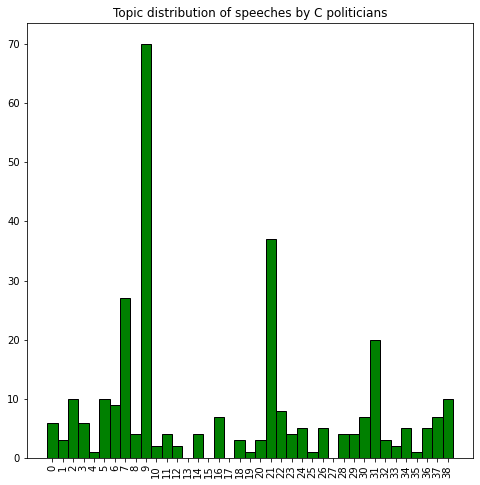

In [58]:
#pred_C = kmeansCV.best_estimator_.predict(speech_vec_C)
pred_C = kmeans39.predict(speech_vec_C)
print(len(pred_C))
plot_topic_distribution(pred_C, topic_dict, 'C')

## V

In [60]:
speeches_V = speeches[speeches.parti == 'V']

tokens_V = custom_preprocess(speeches_V, n_samples=300)
speech_vec_V = vectorizer.transform(tokens_V)

Time taken for 300 speeches: 201.74 seconds


300
Cluster with most data points: 9


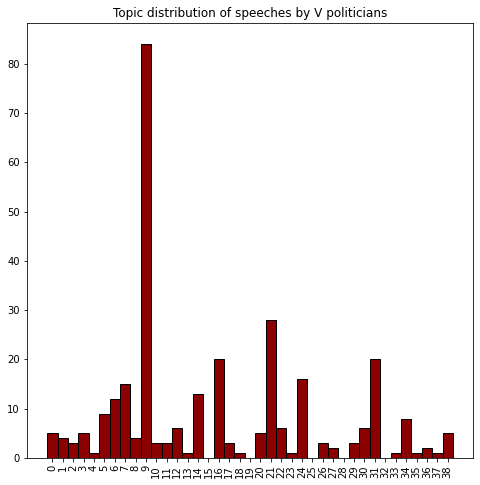

In [61]:
#pred_V = kmeansCV.best_estimator_.predict(speech_vec_V)
pred_V = kmeans39.predict(speech_vec_V)
print(len(pred_V))
plot_topic_distribution(pred_V, topic_dict, 'V')

In [62]:
speaker = 'Ulf Kristersson (M)'
speeches_speaker = speeches[speeches.talare == speaker]
tokens_speaker = custom_preprocess(speeches_speaker, n_samples=1000)
speech_vec_speaker = vectorizer.transform(speeches_speaker.anforandetext)

kmeans_speaker = KMeans(n_clusters = 11)
kmeans_speaker.fit(speech_vec_speaker)

topics_speaker = get_cluster_topics(kmeans_speaker.cluster_centers_, n=10)

Time taken for 1000 speeches: 70.729 seconds
['ett', 'det', 'kan', 'regeringen', 'svenska', 'detta', 'min', 'alla', 'var', 'går']
['det', 'ett', 'skulle', 'regeringen', 'kan', 'alla', 'min', 'människor', 'sverige', 'får']
['det', 'skulle', 'detta', 'vår', 'länder', 'våra', 'politik', 'får', 'kan', 'mig']
['det', 'kan', 'detta', 'ett', 'finns', 'alla', 'regeringen', 'dem', 'skulle', 'eu']
['det', 'min', 'dem', 'oss', 'var', 'saker', 'finns', 'alla', 'hela', 'frågor']
['det', 'detta', 'ett', 'var', 'människor', 'regeringen', 'skulle', 'kan', 'finns', 'svenska']
['det', 'människor', 'ett', 'ser', 'kan', 'dem', 'regeringen', 'partiledardebatt', 'skulle', 'detta']
['det', 'ett', 'regeringen', 'kan', 'detta', 'alla', 'finns', 'var', 'oss', 'svenska']
['det', 'alla', 'kan', 'eu', 'vet', 'ett', 'oss', 'min', 'länder', 'skulle']
['intryck', 'migrationspolitik', 'regeringen', 'ett', 'volymmål', 'det', 'enkla', 'integrationsproblem', 'varv', 'min']
['det', 'länder', 'skulle', 'ett', 'ställer', 'k

Cluster with most data points: 9


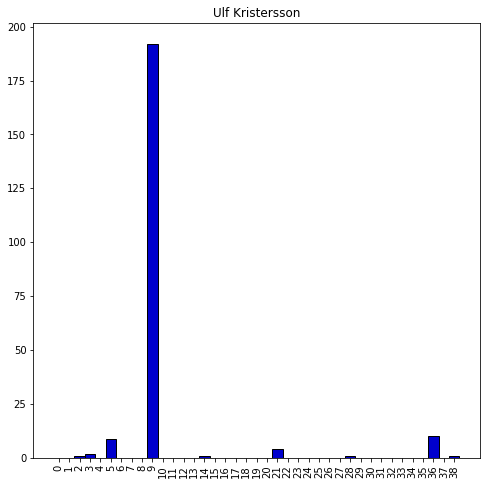

In [63]:
pred_speaker = kmeans39.predict(speech_vec_speaker)
plot_topic_distribution(pred_speaker, topic_dict, 'M', 'Ulf Kristersson')

In [64]:
print(speeches[speeches.talare == 'Statsministern Stefan Löfven (S)'].kammaraktivitet.value_counts(dropna=False))
print(speeches[speeches.talare == 'Annie Lööf (C)'].kammaraktivitet.value_counts(dropna=False))

NaN                           694
statsministerns frågestund    465
Name: kammaraktivitet, dtype: int64
NaN                           184
statsministerns frågestund     20
Name: kammaraktivitet, dtype: int64


## Short analysis
The generic topics dominate even when using a lemmatizer. Perhaps the feature space is too large? Looking at the 300 most common words reveals that they carry relatively little information on the topic. Will the results be improved by throwing away the most common words?

__Another approach might be to remove the speeches that are of no specific category or bring up many topics (e.g. 'frågestund', 'partiledardebatt') and evaluate on the given subject labels (see data inspection).__

One can also try using KBs Swedish spacy POS tagger combined with lemmatizer `lemmy`